In [1]:
from os import path

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
from astropy.wcs import WCS
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree, ConvexHull

from pyia import GaiaData
import gala.dynamics as gd
import gala.coordinates as gc
import gala.potential as gp
from gala.mpl_style import center_emph, center_deemph

from dustmaps.sfd import SFDQuery
from helpers import get_ext

sfd = SFDQuery()

In [8]:
dark_ptstyle = dict(marker='o', markersize=2, markeredgewidth=0,
                    ls='none', alpha=0.75, color='k', rasterized=True)
pcolor_style = dict(cmap='copper', rasterized=True, linewidth=0)

In [30]:
isos = []
for age in [1e8, 2e8, 3e8]:
    iso = Table.read('../data/FeH-1_all.fits')
    iso = iso[np.isclose(iso['isochrone_age_yr'], age)]
    iso = iso[(iso['phase'] >= 0) & (iso['phase'] < 4)]
    isos.append(iso)

iso = iso[np.isclose(iso['isochrone_age_yr'], 1e8)]
iso = iso[(iso['phase'] >= 0) & (iso['phase'] < 4)]

feh = -1

In [3]:
# See: Figure 1 notebook
cluster_c = coord.SkyCoord(ra=179.5*u.deg,
                           dec=-28.8*u.deg)
cluster_r = 1.7 * u.deg

Coefficients from Schlafly+2011, assuming $R_V = 3.1$

In [4]:
u_coeff = 4.1 # from LSST u
g_coeff = 3.237
r_coeff = 2.176
i_coeff = 1.595

In [5]:
g = GaiaData('../data/data-joined.fits')
c = g.get_skycoord(distance=False)

In [6]:
decam = GaiaData('../data/DECam-first-pass.fits')
decam_c = coord.SkyCoord(ra=decam.RA, dec=decam.DEC, unit='deg')

nsc = GaiaData('../data/nsc-only.fits')
nsc_c = coord.SkyCoord(ra=nsc.ra, dec=nsc.dec, unit='deg')

mag_c = decam_c.transform_to(gc.MagellanicStream)

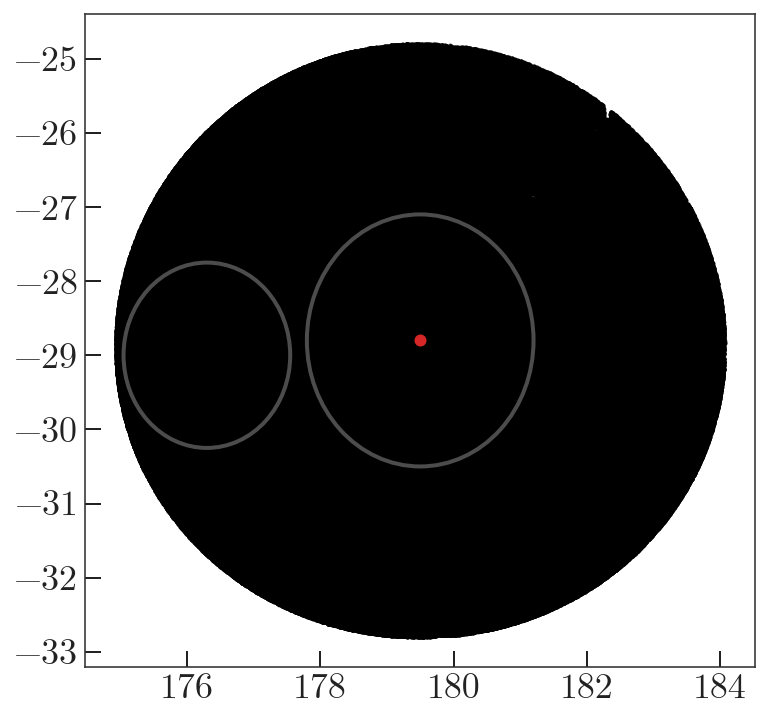

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(nsc_c.ra, nsc_c.dec, **dark_ptstyle)
ax.scatter(cluster_c.ra, cluster_c.dec, marker='o', color='tab:red', zorder=100)
sky_circ = mpl.patches.Circle((179.5, -28.8), radius=1.7, 
                              facecolor='none', edgecolor='#666666', 
                              alpha=0.75, linewidth=2, zorder=100)
ax.add_patch(sky_circ)

# sky_circ = mpl.patches.Circle((178.4, -26.3), radius=1.25, 
#                               facecolor='none', edgecolor='#666666', 
#                               alpha=0.75, linewidth=2, zorder=100)

sky_circ = mpl.patches.Circle((176.3, -29), radius=1.25, 
                              facecolor='none', edgecolor='#666666', 
                              alpha=0.75, linewidth=2, zorder=100)
ax.add_patch(sky_circ)

# control_data = nsc[nsc_c.separation(coord.SkyCoord(ra=178.4, dec=-26.3, unit='deg')) < 1.5*u.deg]
control_data = nsc[nsc_c.separation(coord.SkyCoord(ra=176.3, dec=-29, unit='deg')) < 1.5*u.deg]

In [10]:
ebv = sfd.query(decam_c)

u0 = decam.UMAG - u_coeff * ebv
g0 = decam.GMAG - g_coeff * ebv
i0 = decam.IMAG - i_coeff * ebv

# ebv = decam.ebv

# u0 = decam.umag - u_coeff * ebv
# g0 = decam.gmag - g_coeff * ebv
# r0 = decam.rmag - r_coeff * ebv
# i0 = decam.imag - i_coeff * ebv

In [11]:
gi = g0 - i0
# HACK: to hack the calibration - REMOVE THIS
gi = gi - 0.27

ug = u0 - g0

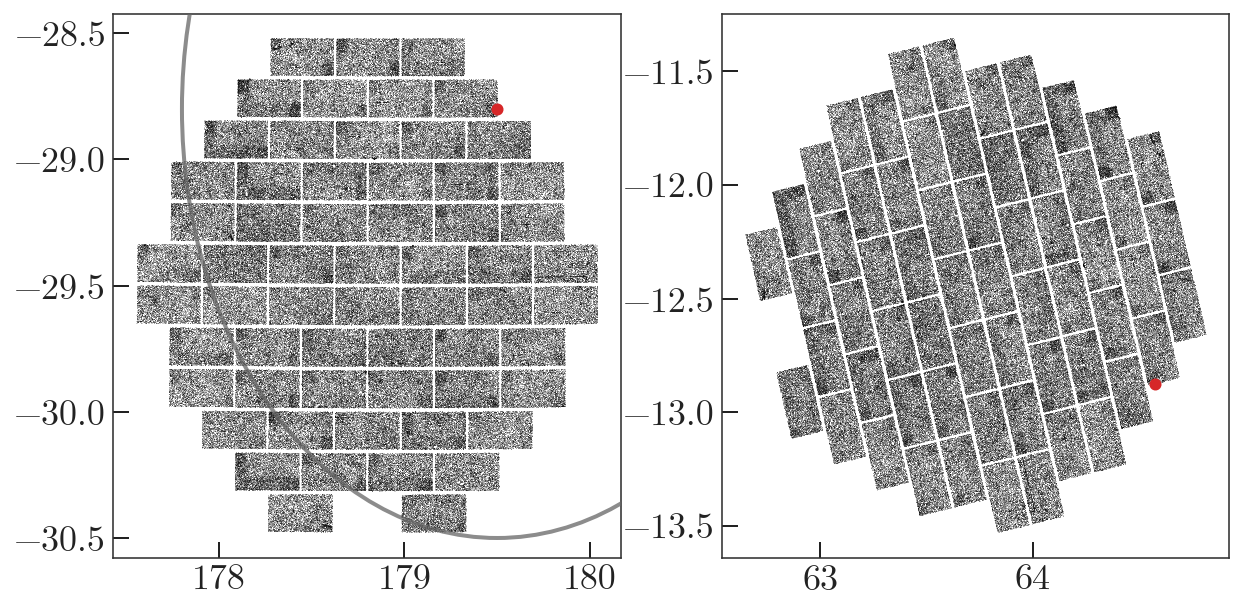

In [12]:
ptstyle = dict(marker=',', ls='none', alpha=0.2, color='k')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(decam_c.ra, decam_c.dec, **ptstyle)
axes[0].scatter(cluster_c.ra, cluster_c.dec, marker='o', color='tab:red', zorder=100)
sky_circ = mpl.patches.Circle((179.5, -28.8), radius=1.7, 
                              facecolor='none', edgecolor='#666666', 
                              alpha=0.75, linewidth=2, zorder=100)
axes[0].add_patch(sky_circ)

axes[1].plot(mag_c.L.degree, mag_c.B.degree, **ptstyle)
axes[1].scatter(cluster_c.transform_to(gc.MagellanicStream).L, 
                cluster_c.transform_to(gc.MagellanicStream).B,
                marker='o', color='tab:red', zorder=100)

In [41]:
control_g0 = control_data.gmag - g_coeff * control_data.ebv
control_i0 = control_data.imag - i_coeff * control_data.ebv
control_gi = control_g0 - control_i0

In [42]:
cl_rough_mask = decam_c.separation(cluster_c) < cluster_r
cl_area = np.pi * cluster_r**2 # approximation

In [43]:
len(control_data), cl_rough_mask.sum()

(401498, 423997)

# TODO: have to re-do this with the properly calibrated data

For now, chop up the isochrone and use to define a polygon selection:

In [17]:
DM = coord.Distance(30*u.kpc).distmod.value

In [18]:
mask = (iso['DECam_g'] > (16-DM)) & (iso['DECam_g'] < (21.5-DM))
iso2 = iso[mask]

lower_x = iso2['DECam_g'] - iso2['DECam_i'] - 0.1
lower_y = iso2['DECam_g'] + DM + 0.2

upper_x = iso2['DECam_g'] - iso2['DECam_i'] + 0.1
upper_y = iso2['DECam_g'] + DM - 0.2

pt1 = np.vstack((lower_x, lower_y)).T
pt2 = np.vstack((upper_x, upper_y)).T
pts = np.vstack((pt1, pt2[::-1]))

/Users/adrian/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


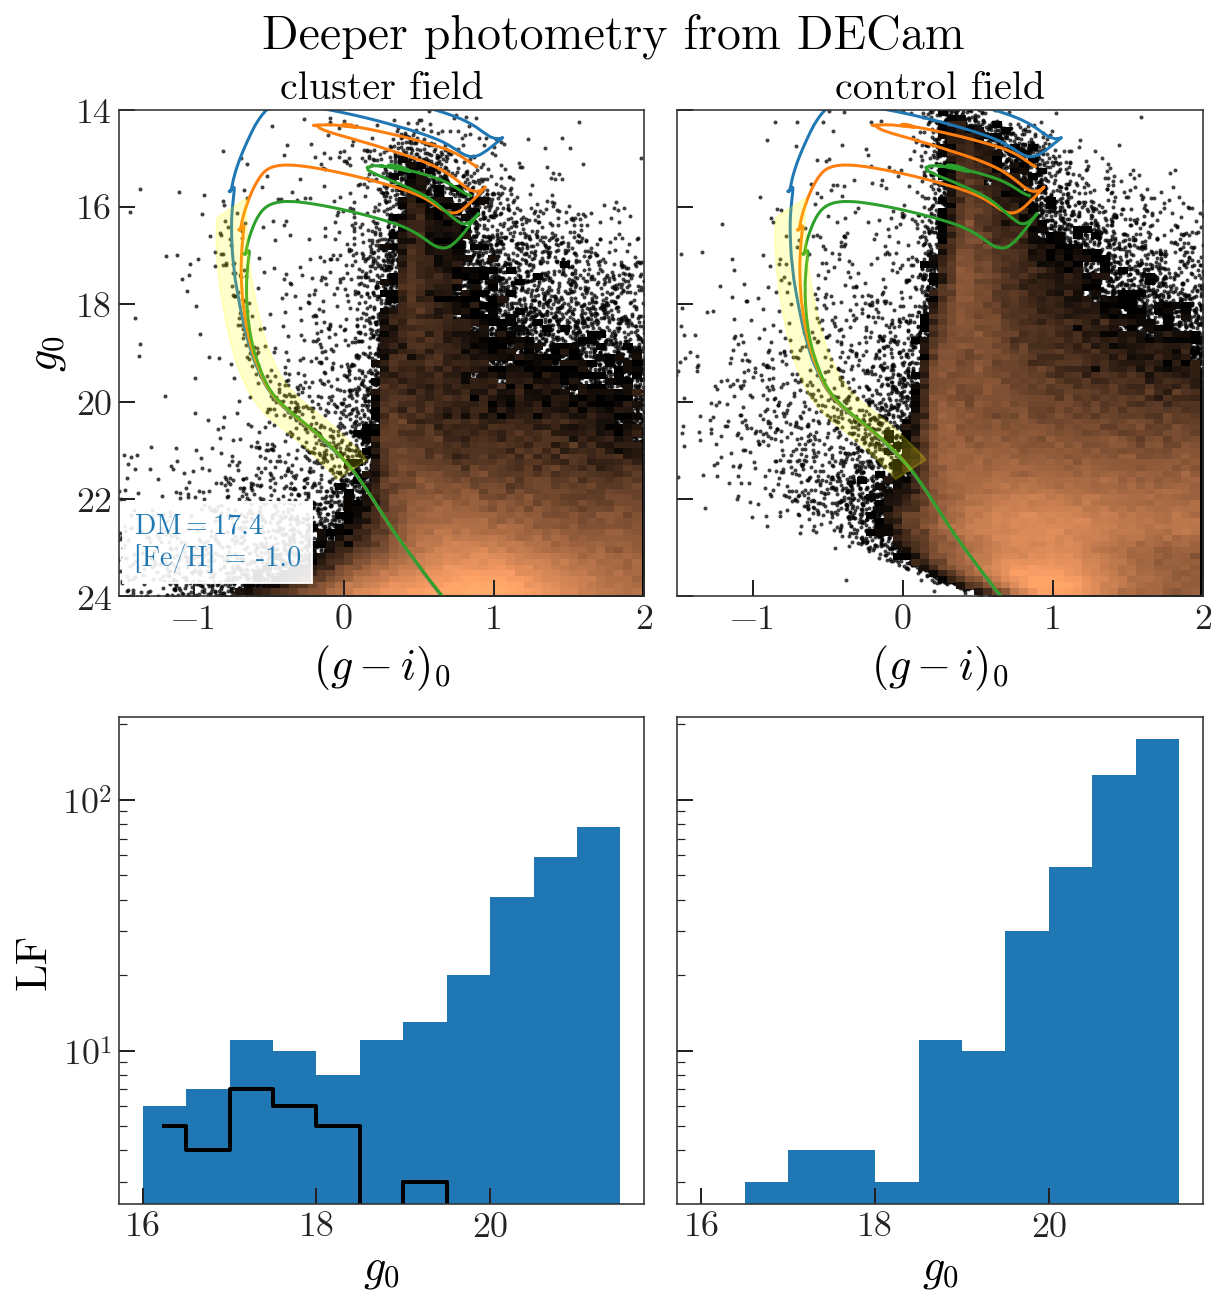

In [44]:
bins = (np.arange(-1.5, 2+1e-3, 0.06),
        np.arange(14, 24+1e-3, 0.12))
pt_thresh = 8
norm = mpl.colors.LogNorm(vmin=pt_thresh+1, vmax=1e3)

H, xe_cmd, ye_cmd = np.histogram2d(control_gi, control_g0, 
                                   bins=bins)
H_bg = H.T
H_bg[H_bg < pt_thresh] = np.nan

H, *_ = np.histogram2d(gi[cl_rough_mask], g0[cl_rough_mask],
                       bins=bins)
H_fg = H.T
H_fg[H_fg < pt_thresh] = np.nan

# ---

fig, all_axes = plt.subplots(2, 2, figsize=(8.4, 9), 
                             sharex='row', sharey='row', 
                             constrained_layout=True)

# ----
# CMD:

axes = all_axes[0]

ax = axes[0]
ax.pcolormesh(xe_cmd, ye_cmd, H_fg, 
              norm=norm,
              **pcolor_style)
ax.plot(gi[cl_rough_mask], g0[cl_rough_mask], 
        zorder=-10, **dark_ptstyle)

ax.text(-1.4, 23.5, r'${{\rm DM}} = {:.1f}$'.format(DM) + '\n' + r'[Fe/H] = {:.1f}'.format(feh),
        va='bottom', backgroundcolor=(1,1,1,0.9), alpha=1, fontsize=14,
        color='tab:blue')

ax.set_xlabel('$(g - i)_0$')
ax.set_ylabel('$g_0$')
ax.set_title('cluster field', fontsize=20)

cmd_poly = mpl.patches.Polygon(pts, color='yellow', zorder=100, alpha=0.2)
cmd_path = cmd_poly.get_path()
ax.add_patch(cmd_poly)

ax = axes[1]
ax.pcolormesh(xe_cmd, ye_cmd, H_bg, 
              norm=norm,
              **pcolor_style)
ax.plot(control_gi, control_g0, 
        zorder=-10, **dark_ptstyle)

for iso in isos:
    for ax in axes:
        ax.plot(iso['DECam_g']-iso['DECam_i'], iso['DECam_g'] + DM,
                marker='')

ax.set_xlabel('$(g - i)_0$')
ax.set_title('control field', fontsize=20)
    
ax.set_xlim(-1.5, 2)
ax.set_ylim(24, 14)

cmd_poly = mpl.patches.Polygon(pts, color='yellow', zorder=100, alpha=0.2)
cmd_path = cmd_poly.get_path()
ax.add_patch(cmd_poly)

# --------------------
# Luminosity function:

cl_cmd_mask = cmd_path.contains_points(np.vstack((gi, g0)).T)
co_cmd_mask = cmd_path.contains_points(np.vstack((control_gi, control_g0)).T)
bins = np.arange(16, 21.5+1e-3, 0.5)

lf_bg, _ = np.histogram(control_g0[co_cmd_mask], bins=bins)
lf_fg, _ = np.histogram(g0[cl_cmd_mask], bins=bins)

axes = all_axes[1]

ax = axes[0]
ax.hist(g0[cl_cmd_mask], bins=bins)
ax.plot(0.5*(bins[:-1]+bins[1:]), lf_fg - lf_bg, 
        marker='', drawstyle='steps-mid', color='k', lw=2)

ax.set_xlabel('$g_0$')
ax.set_ylabel('LF')

ax = axes[1]
ax.hist(control_g0[co_cmd_mask], bins=bins)

ax.set_xlabel('$g_0$')

ax.set_yscale('log')

fig.suptitle('Deeper photometry from DECam', fontsize=24, y=0.99)

# fig.tight_layout()

fig.savefig('../plots/figures/decam_iso.pdf', dpi=200)

In [72]:
fr = coord.SkyOffsetFrame(origin=coord.SkyCoord(178.8*u.deg, -29.5*u.deg))

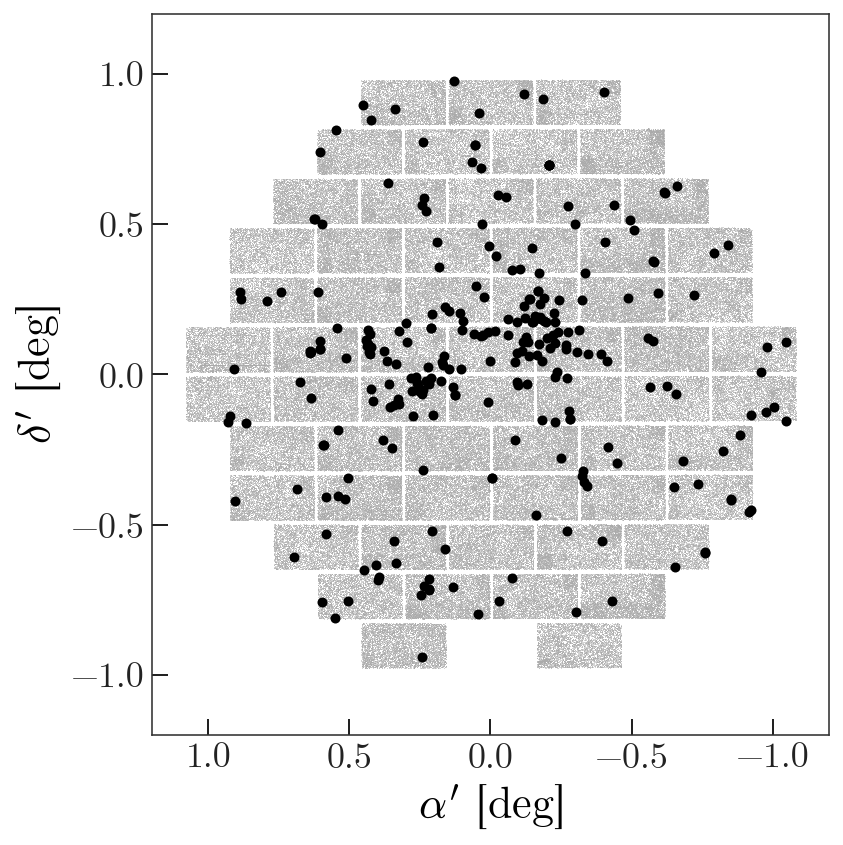

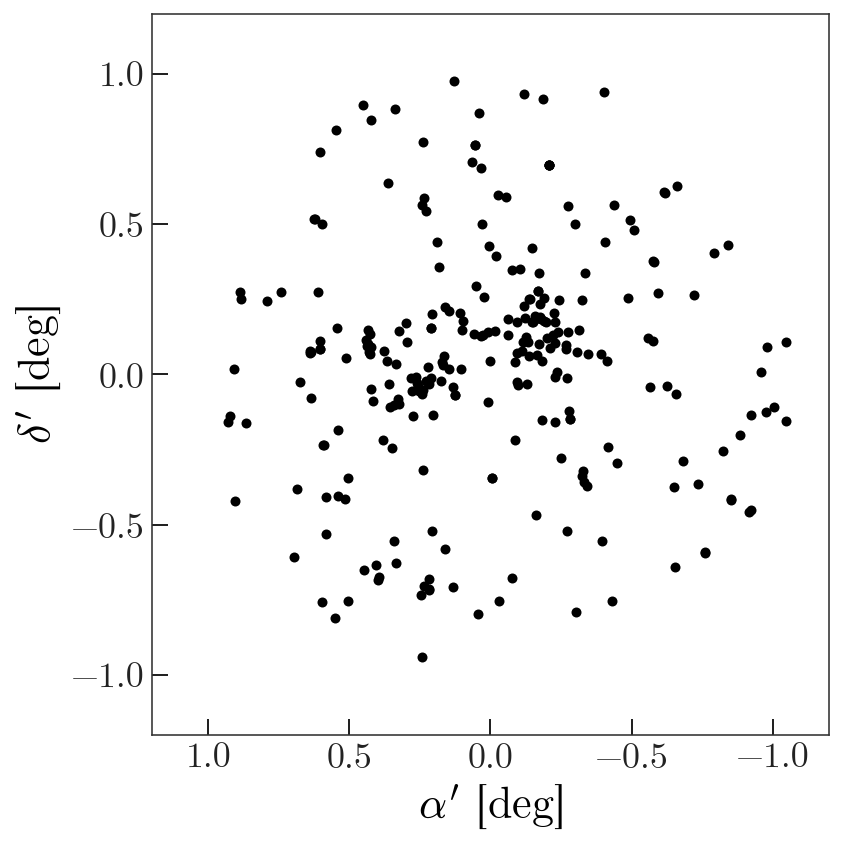

In [81]:
_c = decam_c.transform_to(fr)

for showbg, name in zip([True, False], ['w_bg', 'wo_bg']):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    if showbg:
        ax.plot(_c.lon, _c.lat, 
                marker=',', alpha=0.5, ls='none', color='#aaaaaa')
    ax.plot(_c.lon[cl_cmd_mask], 
            _c.lat[cl_cmd_mask], 
            marker='o', ls='none', color='k')

    ax.set_xlim(1.2, -1.2)
    ax.set_ylim(-1.2, 1.2)

    ax.set_xlabel(r"$\alpha'$ [deg]")
    ax.set_ylabel(r"$\delta'$ [deg]")

    fig.tight_layout()
    fig.savefig('../plots/decam-selected-{0}.png'.format(name), dpi=250)

(-1.2, 1.2)

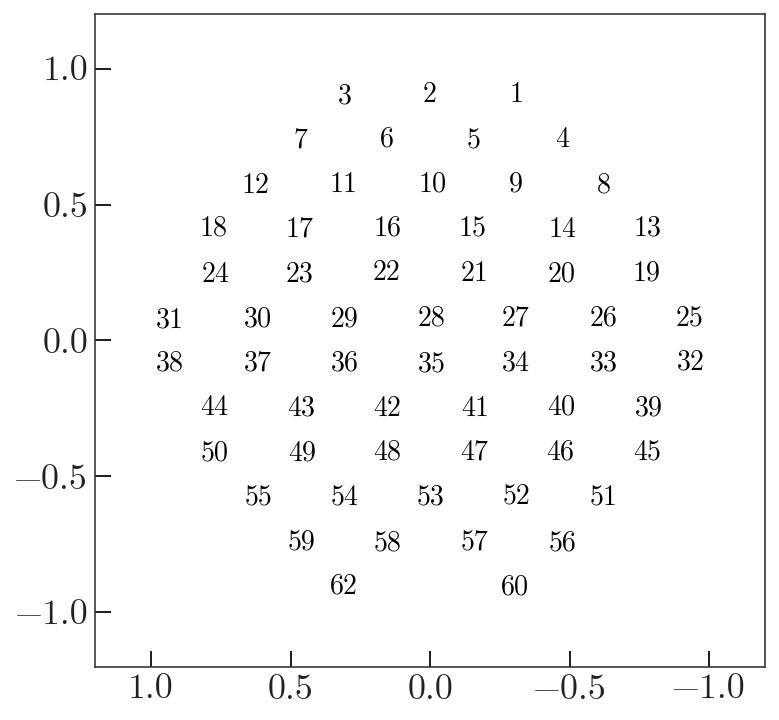

In [99]:
_c = decam_c.transform_to(fr)
unq_ccds = np.unique(decam.EXT)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for ccd in unq_ccds:
    ccd_mask = decam.EXT == ccd
    ccd_c = _c[ccd_mask]
    
    lon = np.mean(ccd_c.lon.degree)
    lat = np.mean(ccd_c.lat.degree)
    
    ax.text(lon, lat, '{0}'.format(ccd), 
            ha='center', va='center', fontsize=14)

ax.set_xlim(1.2, -1.2)
ax.set_ylim(-1.2, 1.2)

# ax.set_xlabel(r"$\alpha'$ [deg]")
# ax.set_ylabel(r"$\delta'$ [deg]")

In [125]:
outer = [1, 2, 3, 7, 12, 18, 25, 31, 38, 44, 50, 55, 59, 62, 57, 60, 56, 51, 45, 39, 32, 19, 13, 8, 4,
         17, 5, 9, 53, 24]
inner = unq_ccds[(~np.isin(unq_ccds, outer)) & (~np.isin(unq_ccds, [48]))]
len(inner), len(outer)

(30, 30)

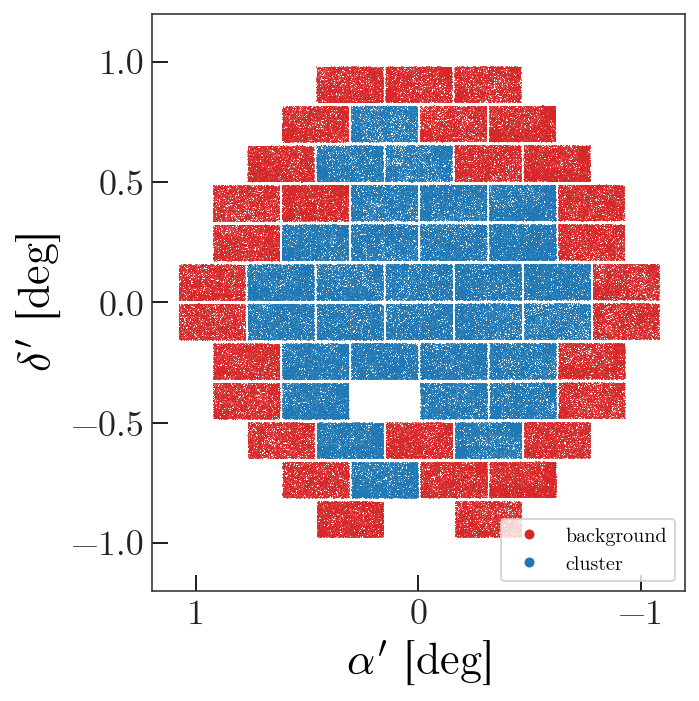

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(800, 800, color='tab:red', 
        marker='o', ls='none', label='background')
ax.plot(800, 800, color='tab:blue', 
        marker='o', ls='none', label='cluster')
ax.legend(loc='lower right', fontsize=10)

for ccd in outer:
    ccd_mask = decam.EXT == ccd
    ccd_c = _c[ccd_mask]
    
    ax.plot(ccd_c.lon, ccd_c.lat, 
            marker=',', alpha=0.75, 
            ls='none', color='tab:red')
    
for ccd in inner:
    ccd_mask = decam.EXT == ccd
    ccd_c = _c[ccd_mask]
    
    ax.plot(ccd_c.lon, ccd_c.lat, 
            marker=',', alpha=0.75, 
            ls='none', color='tab:blue')
    
# ax.plot(_c.lon[cl_cmd_mask], 
#         _c.lat[cl_cmd_mask], 
#         marker='o', ls='none', color='k')
    
ax.set_xlim(1.2, -1.2)
ax.set_ylim(-1.2, 1.2)

ax.set_xlabel(r"$\alpha'$ [deg]")
ax.set_ylabel(r"$\delta'$ [deg]")

fig.tight_layout()
fig.savefig('../plots/decam-fg-bg.png', dpi=250)

In [128]:
control_g0 = g0[np.isin(decam.EXT, outer)]
control_i0 = i0[np.isin(decam.EXT, outer)]
control_gi = gi[np.isin(decam.EXT, outer)]

cluster_g0 = g0[np.isin(decam.EXT, inner)]
cluster_i0 = i0[np.isin(decam.EXT, inner)]
cluster_gi = gi[np.isin(decam.EXT, inner)]

/Users/adrian/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


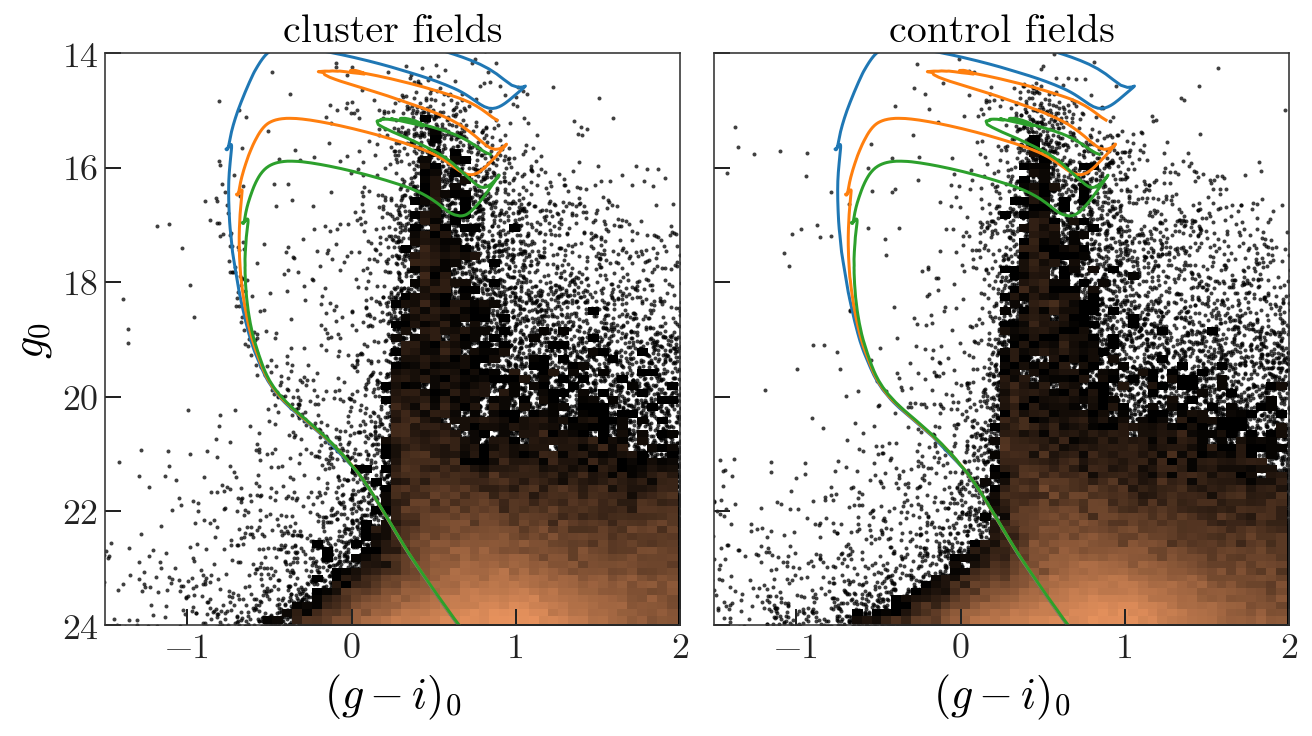

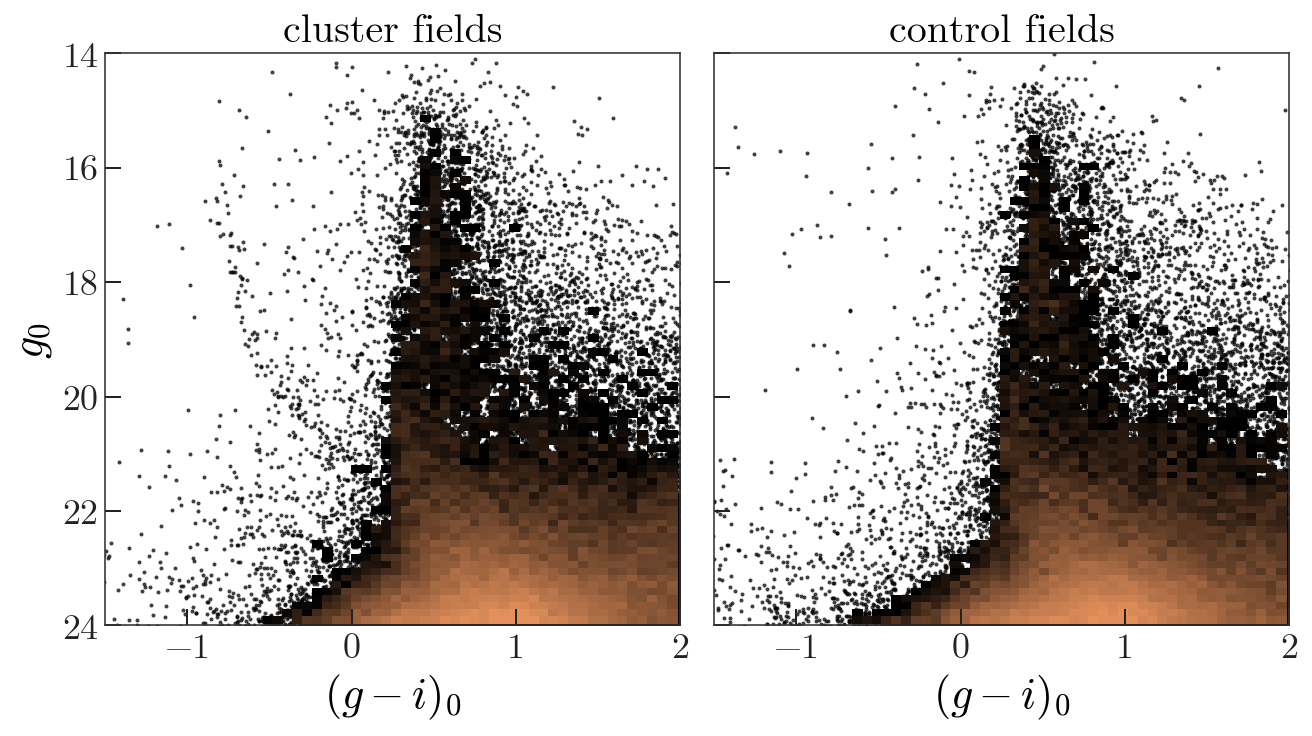

In [136]:
bins = (np.arange(-1.5, 2+1e-3, 0.06),
        np.arange(14, 24+1e-3, 0.12))
pt_thresh = 8
norm = mpl.colors.LogNorm(vmin=pt_thresh+1, vmax=1e3)

H, xe_cmd, ye_cmd = np.histogram2d(control_gi, control_g0, 
                                   bins=bins)
H_bg = H.T
H_bg[H_bg < pt_thresh] = np.nan

H, *_ = np.histogram2d(cluster_gi, cluster_g0, bins=bins)
H_fg = H.T
H_fg[H_fg < pt_thresh] = np.nan

# ---

for showiso, name in zip([True, False], ['w_iso', 'wo_iso']):

    fig, axes = plt.subplots(1, 2, figsize=(9, 5), 
                             sharex='row', sharey='row', 
                             constrained_layout=True)

    # ----
    # CMD:

    ax = axes[0]
    ax.pcolormesh(xe_cmd, ye_cmd, H_fg, 
                  norm=norm,
                  **pcolor_style)
    ax.plot(cluster_gi, cluster_g0,
            zorder=-10, **dark_ptstyle)

    ax.set_xlabel('$(g - i)_0$')
    ax.set_ylabel('$g_0$')
    ax.set_title('cluster fields', fontsize=20)

    ax = axes[1]
    ax.pcolormesh(xe_cmd, ye_cmd, H_bg, 
                  norm=norm,
                  **pcolor_style)
    ax.plot(control_gi, control_g0, 
            zorder=-10, **dark_ptstyle)
    
    if showiso:
        for iso in isos:
            for ax in axes:
                ax.plot(iso['DECam_g']-iso['DECam_i'], iso['DECam_g'] + DM,
                        marker='')

    ax.set_xlabel('$(g - i)_0$')
    ax.set_title('control fields', fontsize=20)

    ax.set_xlim(-1.5, 2)
    ax.set_ylim(24, 14)

    # fig.tight_layout()

    fig.savefig('../plots/figures/decam-cmd-{0}.pdf'.format(name), dpi=200)

In [141]:
mag_c = _c.transform_to(gc.MagellanicStream)

In [143]:
Lms = mag_c.L.wrap_at(180*u.deg)
Bms = mag_c.B

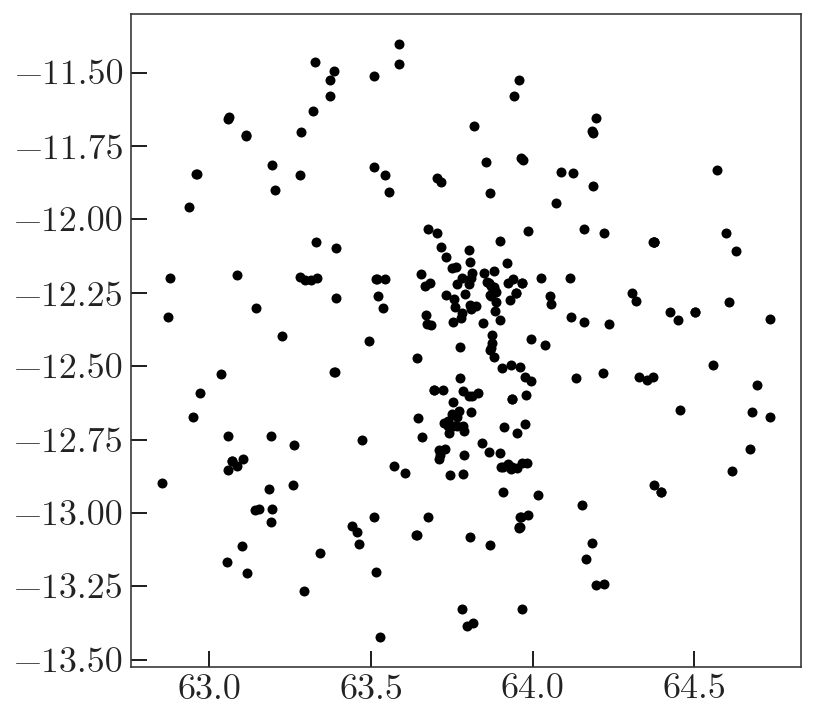

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(Lms[cl_cmd_mask], Bms[cl_cmd_mask], 
        marker='o', ls='none', color='k')

In [148]:
tbl = decam.data[cl_cmd_mask]
tbl['g0'] = g0[cl_cmd_mask]
tbl['i0'] = i0[cl_cmd_mask]
tbl.write('../data/products/decam-selected-PRELIM.fits', overwrite=True)

### Gaia - DECam cross match

In [9]:
idx, sep, _ = decam_c.match_to_catalog_sky(c)

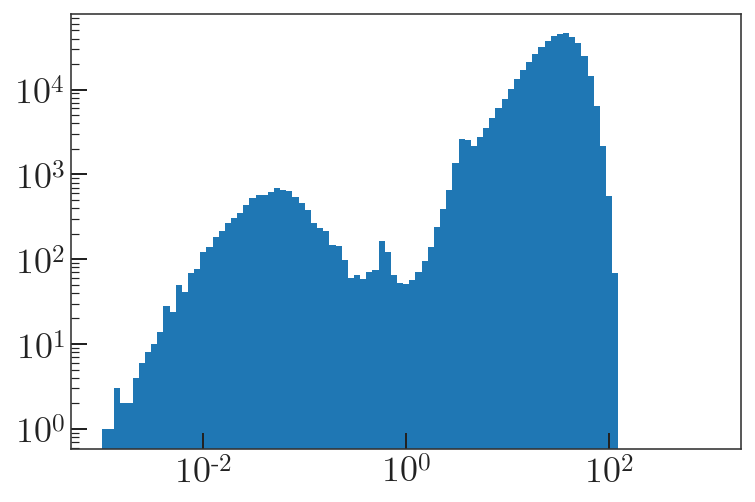

In [10]:
plt.hist(sep.arcsecond, bins=np.logspace(-3, 3, 100));
plt.xscale('log')
plt.yscale('log')

In [15]:
sep_mask = (sep < 1*u.arcsec)

sub_g = g[idx[sep_mask]]
sub_d = decam[sep_mask]

In [16]:
len(sub_g), len(sub_d)

(9896, 9896)

/Users/adrian/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


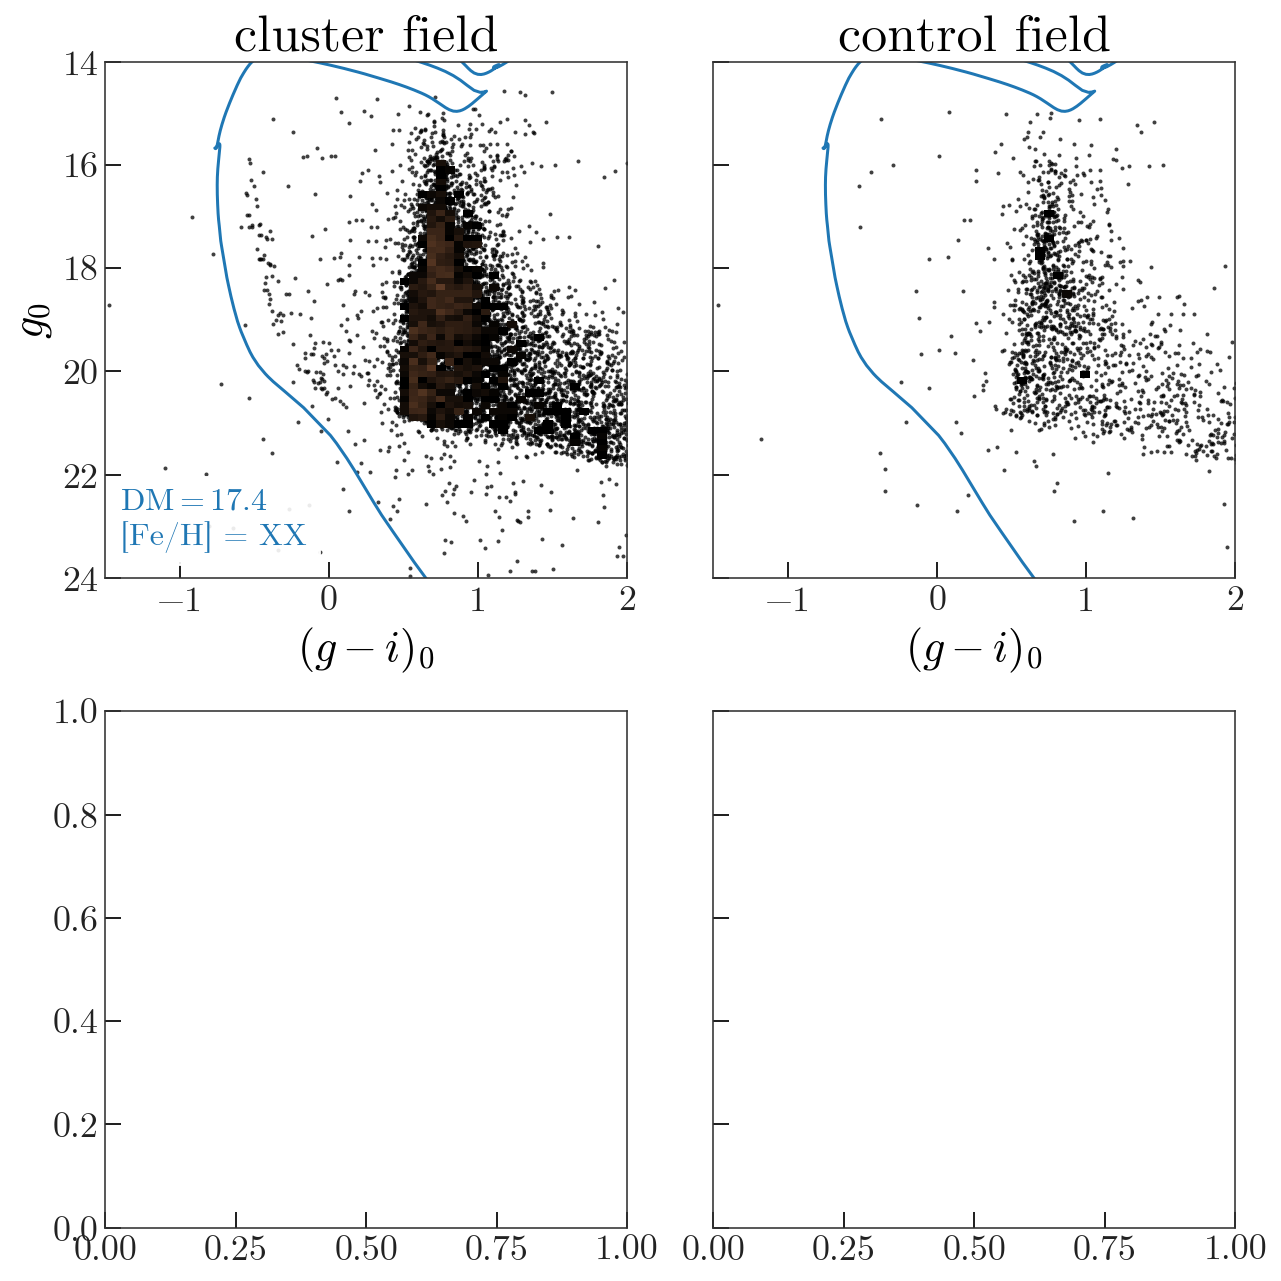

In [106]:
bins = (np.arange(-1.5, 2+1e-3, 0.06),
        np.arange(14, 24+1e-3, 0.12))
pt_thresh = 8
norm = mpl.colors.LogNorm(vmin=pt_thresh+1, vmax=1e3)

H, xe_cmd, ye_cmd = np.histogram2d(gi[sep_mask & control_mask], g0[sep_mask & control_mask], 
                                   bins=bins)
H_bg = H.T
H_bg[H_bg < pt_thresh] = np.nan

H, *_ = np.histogram2d(gi[sep_mask & cl_rough_mask], g0[sep_mask & cl_rough_mask],
                       bins=bins)
H_fg = H.T
H_fg[H_fg < pt_thresh] = np.nan

# ---

fig, all_axes = plt.subplots(2, 2, figsize=(9, 9), 
                             sharex='row', sharey='row')

# ----
# CMD:

axes = all_axes[0]

ax = axes[0]
ax.pcolormesh(xe_cmd, ye_cmd, H_fg, 
              norm=norm,
              **pcolor_style)
ax.plot(gi[sep_mask & cl_rough_mask], g0[sep_mask & cl_rough_mask], 
        zorder=-10, **dark_ptstyle)

ax.text(-1.4, 23.5, r'${{\rm DM}} = {:.1f}$'.format(DM) + '\n' + r'[Fe/H] = XX',
        va='bottom', backgroundcolor=(1,1,1,0.9), alpha=1, fontsize=16,
        color='tab:blue')

ax.set_xlabel('$(g - i)_0$')
ax.set_ylabel('$g_0$')
ax.set_title('cluster field')

ax = axes[1]
ax.pcolormesh(xe_cmd, ye_cmd, H_bg, 
              norm=norm,
              **pcolor_style)
ax.plot(gi[sep_mask & control_mask], g0[sep_mask & control_mask], 
        zorder=-10, **dark_ptstyle)

DM = coord.Distance(30*u.kpc).distmod.value
for ax in axes:
    ax.plot(iso['DECam_g']-iso['DECam_i'], iso['DECam_g'] + DM,
            marker='')

ax.set_xlabel('$(g - i)_0$')
ax.set_title('control field')
    
ax.set_xlim(-1.5, 2)
ax.set_ylim(24, 14)

# --------------------
# Luminosity function:

# ax = axes[1]
# ax.pcolormesh(xe_cmd, ye_cmd, H_bg,
#               norm=mpl.colors.LogNorm())

fig.tight_layout()

---

In [80]:
from astropy.convolution import convolve, Gaussian2DKernel

x_binsize = 0.04
y_binsize = 0.08

x_stddev = 0.05 / x_binsize # mag
y_stddev = 0.1 / y_binsize # mag

K = Gaussian2DKernel(x_stddev=x_stddev, y_stddev=y_stddev)

In [81]:
scale = ( ((gi[control_mask] > 0.5) & (gi[control_mask] < 1.5)).sum() / 
          ((gi[cl_rough_mask] > 0.5) & (gi[cl_rough_mask] < 1.5)).sum() )

H1 = convolve(H_bg, K) / scale
H2 = convolve(H_fg, K)

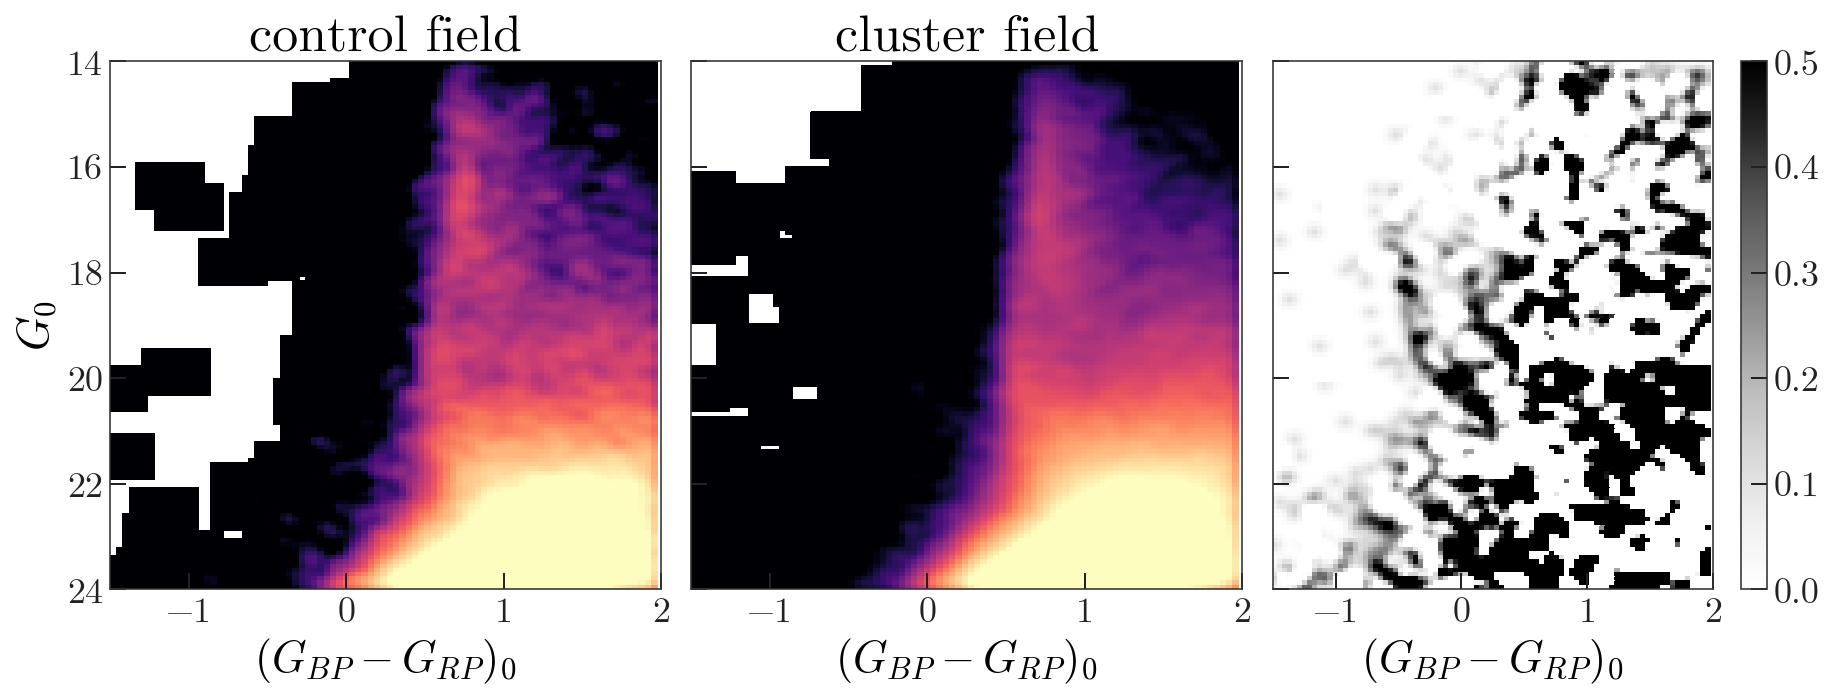

In [87]:
norm = mpl.colors.LogNorm(vmin=1e0, vmax=1e2)

fig, axes = plt.subplots(1, 3, figsize=(9+4, 5), sharex=True, sharey=True)

ax = axes[0]
ax.pcolormesh(xe_cmd, ye_cmd, H1, 
              norm=norm, cmap='magma')
ax.set_xlabel('$(G_{BP} - G_{RP})_0$')
ax.set_ylabel('$G_0$')
ax.set_title('control field')

ax = axes[1]
ax.pcolormesh(xe_cmd, ye_cmd, H2, 
              norm=norm, cmap='magma')
ax.set_xlabel('$(G_{BP} - G_{RP})_0$')
ax.set_title('cluster field')

ax = axes[2]
cs = ax.pcolormesh(xe_cmd, ye_cmd, H2 - H1, 
                   cmap='Greys', vmin=0, vmax=0.5)
ax.set_xlabel('$(G_{BP} - G_{RP})_0$')
# ax.set_title('control field')
fig.colorbar(cs)

ax.set_xlim(-1.5, 2)
ax.set_ylim(24, 14)

fig.tight_layout()